In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import pickle
import helper

/usr/local/Cellar/python3/3.6.3/Frameworks/Python.framework/Versions/3.6/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


In [2]:

training = "traffic-signs-data/train.p"
testing = "traffic-signs-data/test.p"


with open(training, mode='rb') as file:
    train = pickle.load(file) 

with open(testing, mode='rb') as file:
    test = pickle.load(file)

In [3]:
X_tr, Y_tr = train['features'], train['labels']
X_te, Y_te = test['features'], test['labels']

classes = len(set(Y_tr))


print ("Training iputs shape: {}".format(X_tr.shape))
print ("Training labels shape: {}".format(Y_tr.shape))

print ("Testing iputs shape: {}".format(X_te.shape))
print ("Testing labels shape: {}".format(Y_te.shape))
print ("Number of classes {}". format(classes))

Training iputs shape: (39209, 32, 32, 3)
Training labels shape: (39209,)
Testing iputs shape: (12630, 32, 32, 3)
Testing labels shape: (12630,)
Number of classes 43


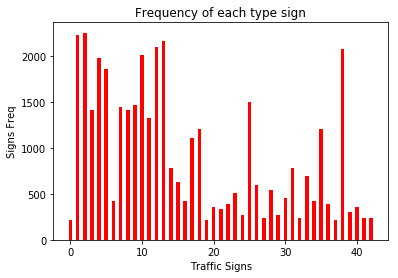

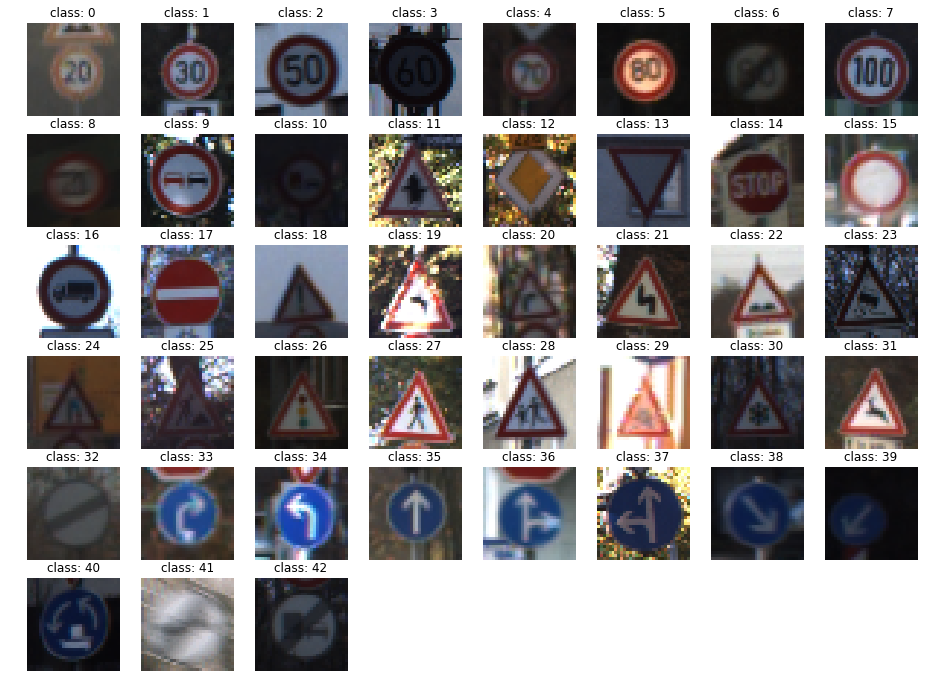

In [4]:
import random as rd

fig, ax = plt.subplots()
ax.bar(range(classes), np.bincount(Y_tr), 0.5, color='r')
ax.set_xlabel('Traffic Signs')
ax.set_ylabel('Signs Freq')
ax.set_title('Frequency of each type sign')
plt.show()

plt.figure(figsize=(16, 16))
for i in range(classes):
    j = rd.choice(np.where(Y_tr == i)[0])
    plt.subplot(8, 8, i + 1)
    plt.axis('off')
    plt.title('class: {}'.format(i))
    plt.imshow(X_tr[j])

In [14]:
tf.reset_default_graph()
sess = tf.Session()
l = len(X_tr)
X_tr = np.reshape(X_tr, (l, 96, 32))
X_te = np.reshape(X_te, (-1, 96, 32))

print(X_tr.shape)
print(X_te.shape)

(39209, 96, 32)
(12630, 96, 32)


In [15]:
def stats(X_batch, Y_batch):
    total_loss = 0
    total_acc = 0
    samples = len(X_batch)
    #X_batch = np.reshape(X_batch, [-1, n_steps, n_inputs])
    sess = tf.get_default_session()
    for offset in range(0, samples, batch_size):
        end = offset+batch_size
        xs_batch, ys_batch = X_batch[offset:end], Y_batch[offset:end]
        loss_, acc = sess.run([loss, accuracy], feed_dict={x:xs_batch, 
                                                           y:ys_batch,
                                                           keep_prob:1.0})
        total_loss += (float(loss_)*xs_batch.shape[0])
        total_acc += (float(acc)*xs_batch.shape[0])

    return (total_loss)/samples, (total_acc)/samples

In [16]:

def RNN(x_, w, b):
    x_ = tf.transpose(x_, [1, 0, 2])
    x_ = tf.reshape(x_, [-1, n_inputs])
    
    
    hidden = tf.matmul(x_, w['hidden']) + b['hidden']
    hidden = tf.nn.relu(hidden)
    hidden = tf.split(hidden, n_steps, 0)
    rnn_layers = [tf.contrib.rnn.DropoutWrapper(tf.contrib.rnn.GRUCell(n_hidden), output_keep_prob=keep_prob) for _ in range(n_layers)]
    rnn_layers = tf.contrib.rnn.MultiRNNCell(rnn_layers)
    outputs, _ = tf.contrib.rnn.static_rnn(rnn_layers, hidden, dtype=tf.float32)
    
    rnn_output = outputs[-1]
    return tf.matmul(rnn_output, w['out']) + b['out']
    
    
    

In [17]:
learning_rate = 1e-3
n_steps = 96 
n_inputs = 32

n_layers = 2
n_hidden = 256
n_classes = classes
batch_size = 128

w = {
    'hidden': tf.Variable(tf.random_normal([n_inputs, n_hidden])),
    'out'   : tf.Variable(tf.random_normal([n_hidden, n_classes]))
}
b = {
    'hidden': tf.Variable(tf.random_normal([n_hidden])),
    'out'  : tf.Variable(tf.random_normal([n_classes]))
}


x = tf.placeholder(dtype=tf.float32, shape=[None, n_steps, n_inputs], name='x')
y = tf.placeholder(dtype=tf.int32, shape=[None], name='y')
keep_prob = tf.placeholder(dtype=tf.float32)
y_hot = tf.one_hot(y, classes, name='one_hot')
#keep_prob = tf.placeholder(dtype=tf.float32, name='keep_prob')


In [18]:
logits = RNN(x, w, b)

In [19]:
softmax = tf.nn.softmax(logits, name='logits')

step = tf.Variable(0, trainable=False)
with tf.name_scope("loss"):
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits, labels=y_hot))
with tf.name_scope("train_step"):
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='optimizer').minimize(loss)

prediction = tf.equal(tf.argmax(softmax, 1), tf.argmax(y_hot, 1))
accuracy = tf.reduce_mean(tf.cast(prediction, tf.float32))

In [20]:
init = tf.global_variables_initializer()
sess.run(init)

In [ ]:

from sklearn.utils import shuffle

train_loss = []
train_acc = []
val_loss = []
val_acc = []
test_loss_ = []
test_acc_ = []
epochs = 1000
samples = len(X_tr)

count = 0
print("Initializing Training")
try:
    for epoch in range(epochs):
        X_tr, Y_tr = shuffle(X_tr, Y_tr)
        for offset in range(0, samples, batch_size):
            end = offset+batch_size                
            xs_batch, ys_batch = X_tr[offset:end], Y_tr[offset:end]           
            loss_, _, acc_ = sess.run([loss, optimizer, accuracy], feed_dict={x: xs_batch, 
                                                                              y: ys_batch,
                                                                              keep_prob: 0.75})    
            if count % 300 == 0:
                print('Epoch {} Loss : {} and Accuracy : {}'.format(epoch, loss_, 100 * acc_))

            train_loss.append(loss_)
            train_acc.append(acc_)
            count += 1
    test_loss_, test_acc_ = sess.run([loss, accuracy], feed_dict={x: X_te, 
                                                                  y: X_te,
                                                                  keep_prob: 1.00}) 

    test_loss_.append(test_loss)
    test_acc_.append(test_acc)
    print ("Test Loss {} and Test Accuracy {:.3f} %".format(test_loss, 100 *test_acc))
except KeyboardInterrupt:
    print('Training interrupted')

Initializing Training
Epoch 0 Loss : 3.0402274131774902 and Accuracy : 12.5
Epoch 0 Loss : 2.6815602779388428 and Accuracy : 23.4375
Epoch 1 Loss : 2.39670729637146 and Accuracy : 37.5
